In [1]:
import os
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import ast
import numpy as np
import datetime
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
print(pipeline('sentiment-analysis')('we love you'))
print(pipeline('sentiment-analysis')('we hate you'))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9998704195022583}]
[{'label': 'NEGATIVE', 'score': 0.9988259673118591}]


In [2]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [3]:
preprocessed_tweet = 'mushroom the psychonaut ape division mushroom too weird to live and too rare to die framed picture a bold collection of psychonaut apes by internationally recognised artist woahjonny nft nfts ethereum eth eth crypto solana bnb avax tezos tron bitcoin btc'

In [4]:
encoded_text = tokenizer(preprocessed_tweet, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = { 'roberta_neg' : scores[0], 'roberta_neu' : scores[1],'roberta_pos' : scores[2]}
print(scores_dict)

{'roberta_neg': 0.298603, 'roberta_neu': 0.5974009, 'roberta_pos': 0.10399604}


In [5]:
def polarity_scores_roberta(example):
    try:
        encoded_text = tokenizer(example, return_tensors='pt')
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        scores_dict = {
            'roberta_neg' : scores[0],
            'roberta_neu' : scores[1],
            'roberta_pos' : scores[2]
        }
    except:
        scores_dict = {
            'roberta_neg' : 0,
            'roberta_neu' : 0,
            'roberta_pos' : 0
        }
    return scores_dict

In [2]:
def read_return_file(folder_path):
    files_path = os.listdir(folder_path)
    files_path.sort()
    data_path_daily = ['{}{}'.format(folder_path,file) for file in files_path]
    data_path_daily = pd.DataFrame(data_path_daily,columns=['File Path'])
    data_path_daily['File Name'] = files_path
    return data_path_daily

In [7]:
for i,file in tqdm(enumerate(read_return_file('Datasets/Processed Tweet/'))):
    try:
        data = pd.read_csv(file,engine='python',index_col=0)
        data['sent_score']= data['clean_tweet'].astype('str').progress_apply(polarity_scores_roberta)
        data.to_csv('{}'.format(file))
    except:
        print(i)
        print(file)
        continue

100%|██████████| 20406/20406 [33:52<00:00, 10.04it/s]
5it [2:44:03, 1968.65s/it]


In [27]:
for i,file in tqdm(enumerate(read_return_file('Datasets/Processed Tweet/'))):
    data = pd.read_csv(file,engine='python',index_col=0)
    if 'POS' not in data.columns:
        try:
            data['sent_score'] = data['sent_score'].apply(lambda x: ast.literal_eval(x))
            data['POS'] = data['sent_score'].apply(lambda x: x['roberta_pos'])
            data['NEU'] = data['sent_score'].apply(lambda x: x['roberta_neu'])
            data['NEG'] = data['sent_score'].apply(lambda x: x['roberta_neg'])
            data.to_csv('{}'.format(file))
        except:
            print(i)
            print(file)
            continue
    else:
        continue

44it [00:16,  2.71it/s]


In [49]:
col_names = ['following','followers','totaltweets','retweetcount','created_at', 'clean_tweet','POS','NEU','NEG']
for i,file in read_return_file('Datasets/Processed Tweet/').iterrows():
    data = pd.read_csv(file['File Path'],engine='python',index_col=0)
    data = data[col_names]
    data['created_at'] = pd.to_datetime(data['created_at'])
    data.to_csv('Datasets/Reduced Tweet Data/{}'.format(file['File Name']))


In [ ]:
#Global Dataset
datapath = read_return_file('Datasets/Reduced Tweet Data/')
global_data = pd.DataFrame()
for i,file in datapath.iterrows():
    data = pd.read_csv(file['File Path'],engine='python',index_col=0)
    global_data = pd.concat([global_data,data],ignore_index=True)

global_data.to_csv('Datasets/sentiment_scores.csv')

In [36]:
#Average Sentiment Score Hourly
start_date = pd.to_datetime('2022-06-01')
end_date = pd.to_datetime('2022-07-14')
sentiment_scores = pd.DataFrame(columns=['POS','NEU','NEG'])
for i, file in tqdm(read_return_file('Datasets/Reduced Tweet Data/').iterrows()):
    data = pd.read_csv(file['File Path'],engine='python',index_col=0)
    data['created_at'] = pd.to_datetime(data['created_at'])
    daily_score = pd.DataFrame(data.groupby([data['created_at'].dt.hour])[['POS','NEU','NEG']].mean())
    #daily_score = pd.DataFrame(data[['POS','NEU','NEG']].mean())
    #daily_score = daily_score.transpose()
    sentiment_scores = pd.concat([sentiment_scores,daily_score],axis=0,ignore_index=True)

sentiment_scores.index = pd.date_range(start=start_date, end=end_date,freq='H')[:-1]
sentiment_scores.to_csv('Datasets/sentiment_scores_average_long.csv')

43it [00:32,  1.31it/s]


In [3]:
#Average Sentiment Score Daily
sentiment_scores = pd.DataFrame(columns=['POS','NEU','NEG'])
for i, file in tqdm(read_return_file('Datasets/Reduced Tweet Data/').iterrows()):
    data = pd.read_csv(file['File Path'],engine='python',index_col=0)
    data['created_at'] = pd.to_datetime(data['created_at'])
    #daily_score = pd.DataFrame(data.groupby([data['created_at'].dt.hour])[['POS','NEU','NEG']].mean().mean())
    daily_score = pd.DataFrame(data[['POS','NEU','NEG']].mean())
    daily_score = daily_score.transpose()
    sentiment_scores = pd.concat([sentiment_scores,daily_score],axis=0,ignore_index=True)

sentiment_scores.to_csv('Datasets/sentiment_scores_average.csv')

43it [00:07,  5.42it/s]


In [29]:
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

In [30]:
followers = data['followers']
followers = pd.DataFrame(followers)
followers['scale'] = scale(followers['followers'])
scale_data = followers['scale']
scale_data = np.array(scale_data)
scale_data = scale_data.reshape(-1,1)
clustering = KMeans(n_clusters=4,random_state=5)
clustering.fit(scale_data)
followers['labels'] = clustering.labels_

In [31]:
# f = plt.figure()
# f.set_figwidth(10)
# f.set_figheight(5)
# cdict = {0:'yellow',1: 'red', 2: 'blue', 3: 'green'}

# scatter_x = np.array(followers.index)
# scatter_y = np.array(followers['followers'])
# group = np.array(followers['labels'])


# fig, ax = plt.subplots(figsize =(10,20))
# fig.set_figwidth = 200
# for g in np.unique(group):
#     ix =np.where(group==g)
#     ax.scatter(scatter_x[ix],scatter_y[ix],c=cdict[g],label=g,s = 100)
#     fig.set_figwidth = 200
# plt.legend()
# plt.show()

In [38]:
for i, file in tqdm(read_return_file('Datasets/Reduced Tweet Data/').iterrows()):
    try:
        data = pd.read_csv(file['File Path'],engine='python',index_col=0)
        data['created_at'] = pd.to_datetime(data['created_at'])
        followers = data['followers']
        followers = pd.DataFrame(followers)
        followers['scale'] = scale(followers['followers'])
        scale_data = followers['scale']
        scale_data = np.array(scale_data)
        scale_data = scale_data.reshape(-1,1)
        clustering = KMeans(n_clusters=50,random_state=5)
        clustering.fit(scale_data)
        data['influence_labels'] = clustering.labels_
        data.to_csv('Datasets/Reduced Tweet Data/{}'.format(file['File Name']))
    except:
        print(file['File Name'])


43it [00:53,  1.24s/it]


In [39]:
#Average Sentiment Score Daily of "Influences" - Excluding the higgest group obtained from KMeans clustering

sentiment_scores_influencer = pd.DataFrame(columns=['POS','NEU','NEG'])
for i, file in read_return_file('Datasets/Reduced Tweet Data/').iterrows():
    data = pd.read_csv(file['File Path'],engine='python',index_col=0)
    #print(data['created_at'][0],file['File Name'])
    influence_count = data['influence_labels'].value_counts()
    data = data[data['influence_labels']!=influence_count.idxmax()]
    daily_score = pd.DataFrame(data[['POS','NEU','NEG']].mean())
    daily_score = daily_score.transpose()
    sentiment_scores_influencer = pd.concat([sentiment_scores_influencer,daily_score],axis=0,ignore_index=True)

sentiment_scores_influencer.to_csv('Datasets/sentiment_scores_influencer_average.csv')

In [44]:
#Average Sentiment Score Hourly of "Influences" - Excluding the higgest group obtained from KMeans clustering
start_date = pd.to_datetime('2022-06-01')
end_date = pd.to_datetime('2022-07-14')
sentiment_scores_influencer = pd.DataFrame(columns=['POS','NEU','NEG'])
for i, file in read_return_file('Datasets/Reduced Tweet Data/').iterrows():
    data = pd.read_csv(file['File Path'],engine='python',index_col=0)
    #print(data['created_at'][0],file['File Name'])
    influence_count = data['influence_labels'].value_counts()
    data = data[data['influence_labels']!=influence_count.idxmax()]
    data['created_at'] = pd.to_datetime(data['created_at'])
    daily_score = pd.DataFrame(data.groupby([data['created_at'].dt.hour])[['POS','NEU','NEG']].mean())
    #daily_score = pd.DataFrame(data[['POS','NEU','NEG']].mean())
    #daily_score = daily_score.transpose()
    sentiment_scores_influencer = pd.concat([sentiment_scores_influencer,daily_score],axis=0,ignore_index=True)

sentiment_scores.index = pd.date_range(start=start_date, end=end_date,freq='H')[:-1]
sentiment_scores_influencer.to_csv('Datasets/sentiment_scores_influencer_average_long.csv')

In [ ]:
#Plot sent score total
#Plot average sent score
#Plot influencer sent score

In [7]:
sentiment_scores_data = pd.read_csv('Datasets/sentiment_scores_average_long.csv',index_col=0)
sentiment_scores_data

,POS,NEU,NEG
2022-06-01 00:00:00,0.193426,0.693996,0.112578
2022-06-01 01:00:00,0.247741,0.627124,0.125135
2022-06-01 02:00:00,0.207945,0.648826,0.143229
2022-06-01 03:00:00,0.271222,0.604784,0.123994
2022-06-01 04:00:00,0.236132,0.650888,0.112979
...,...,...,...
2022-07-13 19:00:00,0.177887,0.628710,0.193403
2022-07-13 20:00:00,0.214906,0.594381,0.190713
2022-07-13 21:00:00,0.231588,0.604233,0.164178
2022-07-13 22:00:00,0.233875,0.591331,0.174794


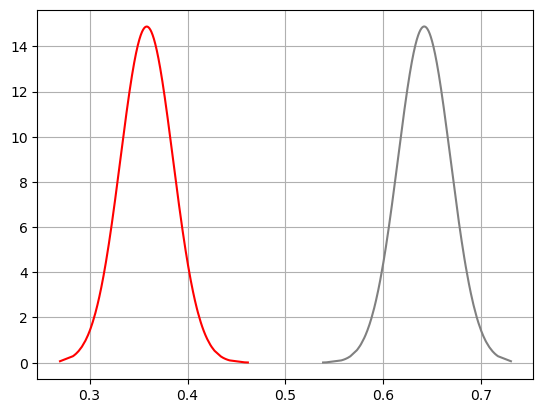

In [25]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

h = list(sentiment_scores_data['POS'])
h.sort()
hmean = np.mean(h)
hstd = np.std(h)
pdf = stats.norm.pdf(h, hmean, hstd)
plt.grid()


g = list(sentiment_scores_data['NEG']+sentiment_scores_data['POS'])
g.sort()
gmean = np.mean(g)
gstd = np.std(g)
gpdf = stats.norm.pdf(g, gmean, gstd)
plt.grid()

i = list(sentiment_scores_data['NEU'])
i.sort()
imean = np.mean(i)
istd = np.std(i)
ipdf = stats.norm.pdf(i, imean, istd)
plt.grid()



#plt.plot(h, pdf,c='red') # including h here is crucial
plt.plot(g, gpdf,c='red') # including h here is crucial
plt.plot(i, ipdf,c='grey') # including h here is crucial

In [24]:
len(i)

1032